<center> <h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Exploration des fichiers <b>"small_vocab_en"</b> et <b>"small_vocab_fr"</b><br>
et 5eme version de traduction mot à mot,<br>
en mode non supervisé et supervisé
<hr style="border-width:2px;border-color:#1664c8">
</center> </h1></bold>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

> **Importation des bibliothèques :**

In [2]:
%matplotlib inline
import os
import time
import contextlib
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

> **Choisir les options d'execution (en fonction du temps disponible)**

In [3]:
# Indiquer si l'on veut enlever les stop words. C'est un processus long
stopwords_to_do = True
# Indiquer si l'on veut lemmatiser les phrases, un fois les stop words enlevés. C'est un processus long
lemmatize_to_do = True
# ====
if not stopwords_to_do:
    lemmatize_to_do = False

> **Définition d'une fonction pour lire les fichiers small_vocab en anglais et en français, et conversion en minuscules :**

In [4]:
def load_data(path):

# Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
        
    # On convertit les majuscules en minulcule
    data = data.lower()
    
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

> **Définition d'une fonction de nettoyage des phrases non traduites, i.e. identiques dans les 2 langues**

In [5]:
def clean_untranslated_sentence(data1, data2):
    i=0
    while i<len(data1):
        if data1[i]==data2[i]:
            data1.pop(i)
            data2.pop(i)
        else: i+=1
    return data1,data2

> **Correction des fautes d'orthographe**
>
> Les données textuelles telles que les textes des médias sociaux contiennent parfois des fautes d'orthographe. Elles doivent être rectifiées dès le début de la phase de nettoyage. Heureusement, nous disposons de bibliothèques pour corriger l'orthographe.

In [6]:
from spellchecker import SpellChecker

def correct_spellings(text, l):

    spell = SpellChecker(language=l)
    corrected_words = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            cw = (spell.correction(word))
            if not cw:
                cw=word
            else:
                corrected_words.append(spell.correction(word))
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

text = "Spelling correctin is proprly perfrmed"
text = correct_spellings(text,'en')
print(text)
text = "Correction d' ecritur est corretement réalisée"
text = correct_spellings(text,'fr')
print(text)

Spelling correcting is properly performed
Correction de écriture est correctement réalisée


> **Elimination des mots indésirable et des mots transparents** (non porteur de sens)
>
> Les textes contiennent de nombreux éléments qui ne sont pas utiles pour le traitement de texte et il est préférable de les éliminer avant la modélisation. 

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
with contextlib.redirect_stdout(open(os.devnull, "w")):
    nltk.download('stopwords')
    
def remove_stopwords(text, lang): 
    stop_words = set(stopwords.words(lang))
    # stop_words will contain  set all english stopwords
    filtered_sentence = []   
    for word in text.split(): 
        if word not in stop_words: 
            filtered_sentence.append(word) 
    return " ".join(filtered_sentence)

def clean_undesirable_from_text(sentence, lang):

    # Removing URLs 
    sentence  = re.sub(r"https?://\S+|www\.\S+", "", sentence )
    
    # Removing Additional Spaces
    sentence = re.sub(' +', ' ', sentence)
    
    # Removing Punctuations (we keep the ' character)
    REPLACEMENTS = [(".", " "),
                    (",", " "),
                    (";", " "),
                    (":", " "),
                    ("?", " "),
                    ('"', " "),
                    ("-", " "),
                    ("it's", "it is"),
                    ("isn't","is not"),
                    ("'", " ")
                   ]
    for old, new in REPLACEMENTS:
        sentence = sentence.replace(old, new)
    
    # Removing Digits
    sentence= re.sub(r'[0-9]','',sentence)

    return sentence

# clean_undesirable_from_text("Hello     , Do you like the:;:?' 45678 this is True https://www.google.com/search?client=firefox-b-d&q=pyspellchecker .", 'english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> **Définition d'un fonction de lemmatisation**

In [8]:
import spacy
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')

def lemmatize(sentence,lang):
    # Create a Doc object
    if lang=='en':
        nlp=nlp_en
    elif lang=='fr':
        nlp=nlp_fr
    else: return
    doc = nlp(sentence)

    # Create list of tokens from given string
    tokens = [] 
    for token in doc:
        tokens.append(token)

    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
 
    return lemmatized_sentence

# s= 'the bats saw the cats with best stripes hanging upside down by their feet'
# print(s)
# print(lemmatize(s,'en'))
# s ="les chauves souris ont vu les chats avec les meilleures rayures suspendus a l'envers par les pieds"
# print(s)
# print(lemmatize(s,'fr'))

> **Définition d'une fonction de splitage des phrases en mots, après nettoyage :**

In [9]:
from nltk.tokenize import word_tokenize

def split_sentence (sentence,lang):

    # On nettoie la phrase
    # sentence = correct_spellings(sentence, lang)
    sentence = clean_undesirable_from_text(sentence, lang)
    
    # On crée un tableau de mots, sentence_split
    
    ## Méhode manuelle
    #sentence_split = sentence.split()
    ## Méthode avec nltk
    sentence_split = word_tokenize(sentence)

    return sentence, sentence_split
    

> **Préprocessing du texte pour pouvoir l'analyser**
>> **(a)** Elimination de la ponctuation, des url, des chiffres
>>
>> **(b)** Elimination des pmots transparent
>>
>> **(c)** Splitage du texte en mots
>>
>> **(d)** Lemmatisation
>>
>> **(e)** Définition du corpus de mots utilisé
>>
>> **(f)** Comptage, dans chaque phrase, du nombre de mots uniques qui se trouvent dans le corpus

In [10]:
###
### Définition de la fonction preprocess_txt
###

def preprocess_txt (data, lang):

    word_count = collections.Counter()
    corpus = []
    data_split = []
    sentence_length = []
    data_split_wo_stopwords = []
    data_length_wo_stopwords = []
    data_lem = []
    data_lem_length = []
    
    # Création d'un tableau de mot (sentence_split) et d'un corpus de mots (corpus)
    for i,sentence in enumerate(data):
        
        # Pour chaque phrase, on crée un tableau de mots, sentence_split
        data[i], sentence_split = split_sentence(sentence,lang)

        # Pour chaque mot de la phrase on vérifie s'il appartient au corpus de mots déjà trouvés.
        # Si ce n'est pas le cas, on le rajoute à corpus
        
        ## Manual count
        # for t in sentence_split:
        #    if t not in corpus:
        #        corpus.append(t)
        
        ## Counter method count
        word_count.update(sentence_split)
        data_split.append(sentence_split)
        sentence_length.append(len(sentence_split))
        
        if lang == 'en': l='english'
        elif lang=='fr': l='french'
        else: l="unknown"
        if l!="unknown":
            # Removing Stopwords
            if stopwords_to_do:
                data_wosw = remove_stopwords(data[i],l)
                data_split_wo_stopwords.append(data_wosw.split())
                data_length_wo_stopwords.append(len(data_wosw.split()))
        
                # Lemmatisation
                if lemmatize_to_do:
                    data_lemmatized = lemmatize(data_wosw,lang).split()
                    data_lem.append(data_lemmatized)    
                    data_lem_length.append(len(data_lemmatized))

    # Affichage des 5 premiers txt_split
    for i in range(5):
        print('Texte "splited"     ',i,':',data_split[i])
        if stopwords_to_do:
            print('Texte sans stopwords',i,':',data_split_wo_stopwords[i])
        if lemmatize_to_do:
            print('Texte lemmatisé     ',i,':',data_lem[i])

        # Si langue anglaise, affichage du taggage des mots
        if lang == 'en':
            print("Texte avec Tags     ",i,":",nltk.pos_tag(data_split[i]))
    print("")
    
    # Affichage du corpus de mots uniques
    corpus = list(word_count.keys())
    nb_phrases = len(data)
    nb_mots = len(corpus)
    mots_wo_sw = remove_stopwords("".join([(w+" ") for w in corpus]),l).split()
    nb_mots_wo_stopword = len(mots_wo_sw)
    mots_lem = lemmatize("".join([(w+" ") for w in mots_wo_sw]),lang).split()
    nb_mots_lem = len(mots_lem)
    
    print("Nombre de phrases                     : ",nb_phrases)
    print("Nombre de mots uniques                : ",nb_mots)
    if stopwords_to_do:
        print("Nombre de mots uniques sans stop words: ", nb_mots_wo_stopword )
    if lemmatize_to_do:
        print("Nombre de mots uniques lemmatisés     : ", nb_mots_lem )
    print("\nMots uniques:")
    print(corpus[:500])
    print("\nMots uniques sans stop words:")
    print(mots_wo_sw[:500])
    print("\nMots uniques kemmatisés:")
    print(mots_lem[:500])
    
    # Création d'un DataFrame txt_n_unique_val :
    #      colonnes = mots
    #      lignes = phases
    #      valeur de la cellule = nombre d'occurence du mot dans la phrase

    
    ## BOW
    from sklearn.feature_extraction.text import CountVectorizer
    count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1, 1), token_pattern=r"[^' ']+" )
    
    # Calcul du nombre d'apparition de chaque mot dans la phrases
    countvectors = count_vectorizer.fit_transform(data)
    corpus = count_vectorizer.get_feature_names_out()
 

    ## TF-IDF
    # from sklearn.feature_extraction.text import TfidfVectorizer
    # tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=r"[^' ']+")

    # countvectors = tfidf_vectorizer.fit_transform(data)
    # corpus = tfidf_vectorizer.get_feature_names_out()
    
    
    ## Manual count
    # txt_n_unique_val = pd.DataFrame(columns=corpus,dtype='int',index=range(nb_phrases))
    # txt_n_unique_val.fillna(0, inplace=True)
    # for i,sentence_split in enumerate(data_split):
    #     for word in sentence_split:
    #         txt_n_unique_val.iloc[i,corpus.index(word)] += 1
    # df1 = txt_n_unique_val

    txt_n_unique_val=  pd.DataFrame(columns=corpus,index=range(nb_phrases), data=countvectors.todense()).astype(float)
    print("\nNombre d'apparitions de chaque mot dans la phrase:")
    display(txt_n_unique_val.iloc[:,:40].head(10))
    print("========\n")

    return data, corpus, data_split, txt_n_unique_val, sentence_length, data_length_wo_stopwords, data_lem_length

In [11]:
#Chargement des textes dans les 2 langues (max lignes = max_lines)
txt_en = load_data('data/small_vocab_en')
txt_fr = load_data('data/small_vocab_fr')

# Elimination des phrases non traduites
txt_en, txt_fr = clean_untranslated_sentence(txt_en, txt_fr)

# Affichage des 20 premieres lignes des textes dans les 2 langues
for i in range(20):
    print("EN: ",txt_en[i])
    print("FR: ",txt_fr[i],"\n")
print("========\n")

# Lancement du préprocessing du texte qui va spliter nettoyer les phrases et les spliter en mots 
# et calculer nombre d'occurences des mots dans chaque phrase
print("Préprocessing de small_vocab_en :\n")
txt_en, corpus_en, txt_split_en, df_count_word_en,sent_len_en, sent_wo_sw_len_en, sent_lem_len_en  = preprocess_txt (txt_en,'en')

print("Préprocessing de small_vocab_fr :\n")
txt_fr, corpus_fr, txt_split_fr, df_count_word_fr,sent_len_fr, sent_wo_sw_len_fr, sent_lem_len_fr  = preprocess_txt (txt_fr,'fr')


EN:  new jersey is sometimes quiet during autumn , and it is snowy in april .
FR:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril . 

EN:  the united states is usually chilly during july , and it is usually freezing in november .
FR:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . 

EN:  california is usually quiet during march , and it is usually hot in june .
FR:  california est généralement calme en mars , et il est généralement chaud en juin . 

EN:  the united states is sometimes mild during june , and it is cold in september .
FR:  les états-unis est parfois légère en juin , et il fait froid en septembre . 

EN:  your least liked fruit is the grape , but my least liked is the apple .
FR:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . 

EN:  his favorite fruit is the orange , but my favorite is the grape .
FR:  son fruit préféré est l'orange , mais mon préféré est le raisin . 

EN

,a,am,and,animal,animals,apple,apples,april,are,aren,...,cats,chilly,china,chinese,cold,december,did,didn,difficult,dislike
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Préprocessing de small_vocab_fr :

Texte "splited"      0 : ['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', 'l', 'automne', 'et', 'il', 'est', 'neigeux', 'en', 'avril']
Texte sans stopwords 0 : ['new', 'jersey', 'parfois', 'calme', 'pendant', 'automne', 'neigeux', 'avril']
Texte lemmatisé      0 : ['new', 'jersey', 'parfois', 'calme', 'pendant', 'automne', 'neigeux', 'avril']
Texte "splited"      1 : ['les', 'états', 'unis', 'est', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'gèle', 'habituellement', 'en', 'novembre']
Texte sans stopwords 1 : ['états', 'unis', 'généralement', 'froid', 'juillet', 'gèle', 'habituellement', 'novembre']
Texte lemmatisé      1 : ['état', 'uni', 'généralement', 'froid', 'juillet', 'gèle', 'habituellement', 'novembr']
Texte "splited"      2 : ['california', 'est', 'généralement', 'calme', 'en', 'mars', 'et', 'il', 'est', 'généralement', 'chaud', 'en', 'juin']
Texte sans stopwords 2 : ['california', 'généralement', 'calme', 'mars', 'générale

,a,agréable,aimait,aime,aiment,aimeraient,aimez,aimons,aimé,aimée,...,avez,avons,avril,banane,bananes,beau,belle,bien,blanc,blanche
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> **Affichage d'un Word Cloud du corpus anglais**

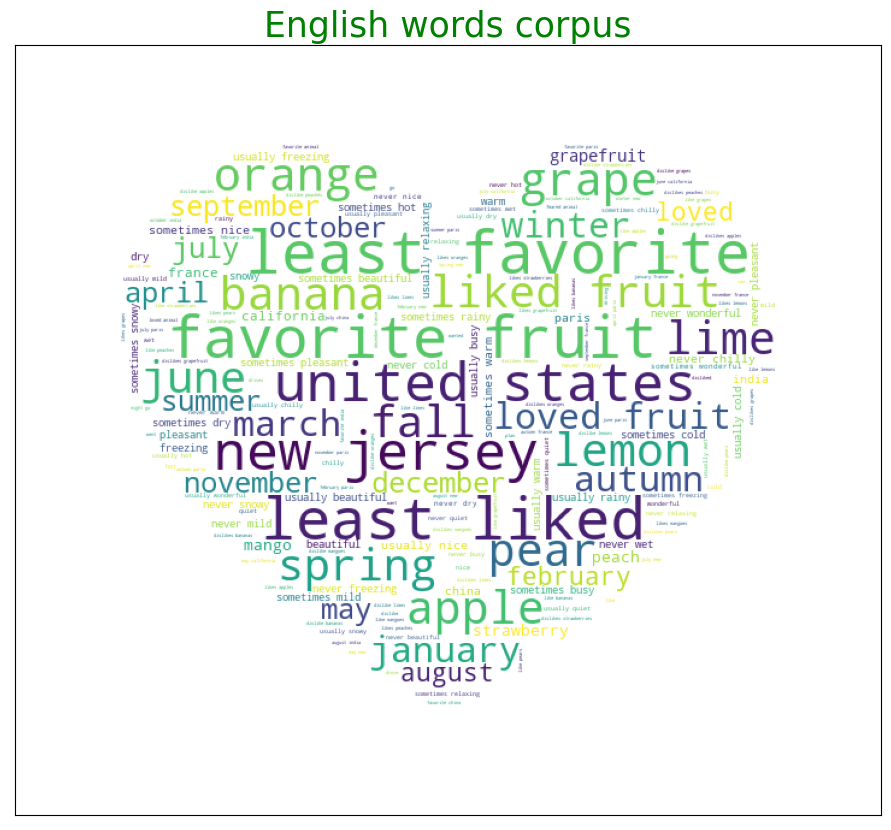

In [12]:
from PIL import Image
from wordcloud import WordCloud

def plot_word_cloud(text, masque, background_color = "white"):
    mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=200, 
                   stopwords=stop_words, mask = mask_coloring, 
                   max_font_size=50, random_state=42)
    # Générer et afficher le nuage de mots
    fig=plt.figure(figsize= (20,10))
    plt.title("English words corpus", fontsize=25, color="green")
    wc.generate(text)
    
    # getting current axes
    a = plt.gca()
 
    # set visibility of x-axis as False
    xax = a.axes.get_xaxis()
    xax = xax.set_visible(False)
 
    # set visibility of y-axis as False
    yax = a.axes.get_yaxis()
    yax = yax.set_visible(False)
    
    plt.imshow(wc)
    plt.show()

text = ""
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('english'))

for e in txt_en : text += e
plot_word_cloud(text, "./images/coeur.png")

> **Calcul du nombre d'occurences des mots dans chaque langue**

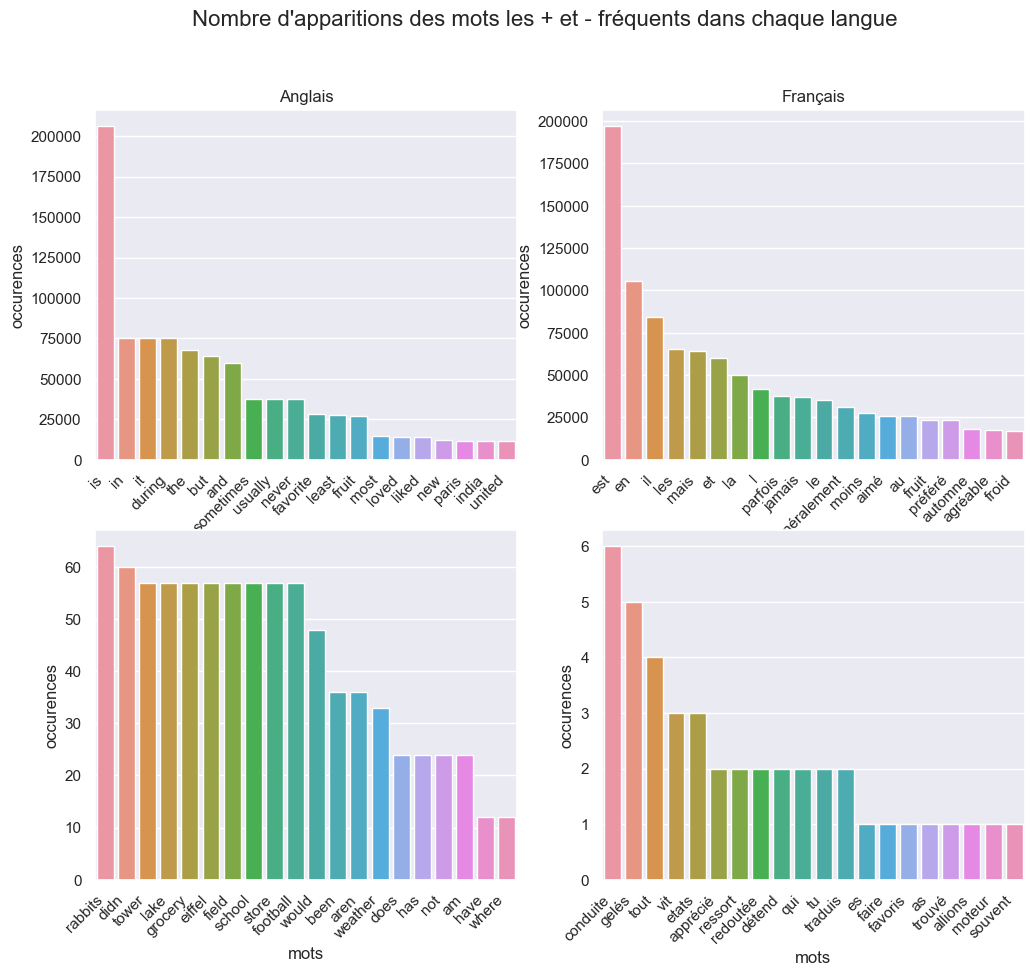

In [13]:
global nb_occurences_en, nb_occurences_fr

nb_occurences_en = pd.DataFrame(df_count_word_en.sum().sort_values(axis=0,ascending=False))
nb_occurences_en.columns = ['occurences']
nb_occurences_en.index.name = 'mot'
#print("Nombre d'occurences des mots en anglais:")
#display(nb_occurences_en)
nb_occurences_en['mots'] = nb_occurences_en.index


nb_occurences_fr = pd.DataFrame(df_count_word_fr.sum().sort_values(axis=0,ascending=False))
nb_occurences_fr.columns = ['occurences']
nb_occurences_fr.index.name = 'mot'
#print("\nNombre d'occurences des mots en français:")
#display(nb_occurences_fr)
nb_occurences_fr['mots'] = nb_occurences_fr.index

sns.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Nombre d'apparitions des mots les + et - fréquents dans chaque langue", fontsize=16)
axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')

chart1 = sns.barplot(ax=axes[0,0],x='mots',y='occurences',data=nb_occurences_en.iloc[:20]);
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')

chart2 = sns.barplot(ax=axes[0,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[:20]);
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')

chart3 = sns.barplot(ax=axes[1,0],x='mots',y='occurences',data=nb_occurences_en.iloc[-20:]);
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=45, horizontalalignment='right')

chart4 = sns.barplot(ax=axes[1,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[-20:]);
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right');

> **Distribution des longueurs de phrases**
>
>On constate une grande similitude entre les 2 langues

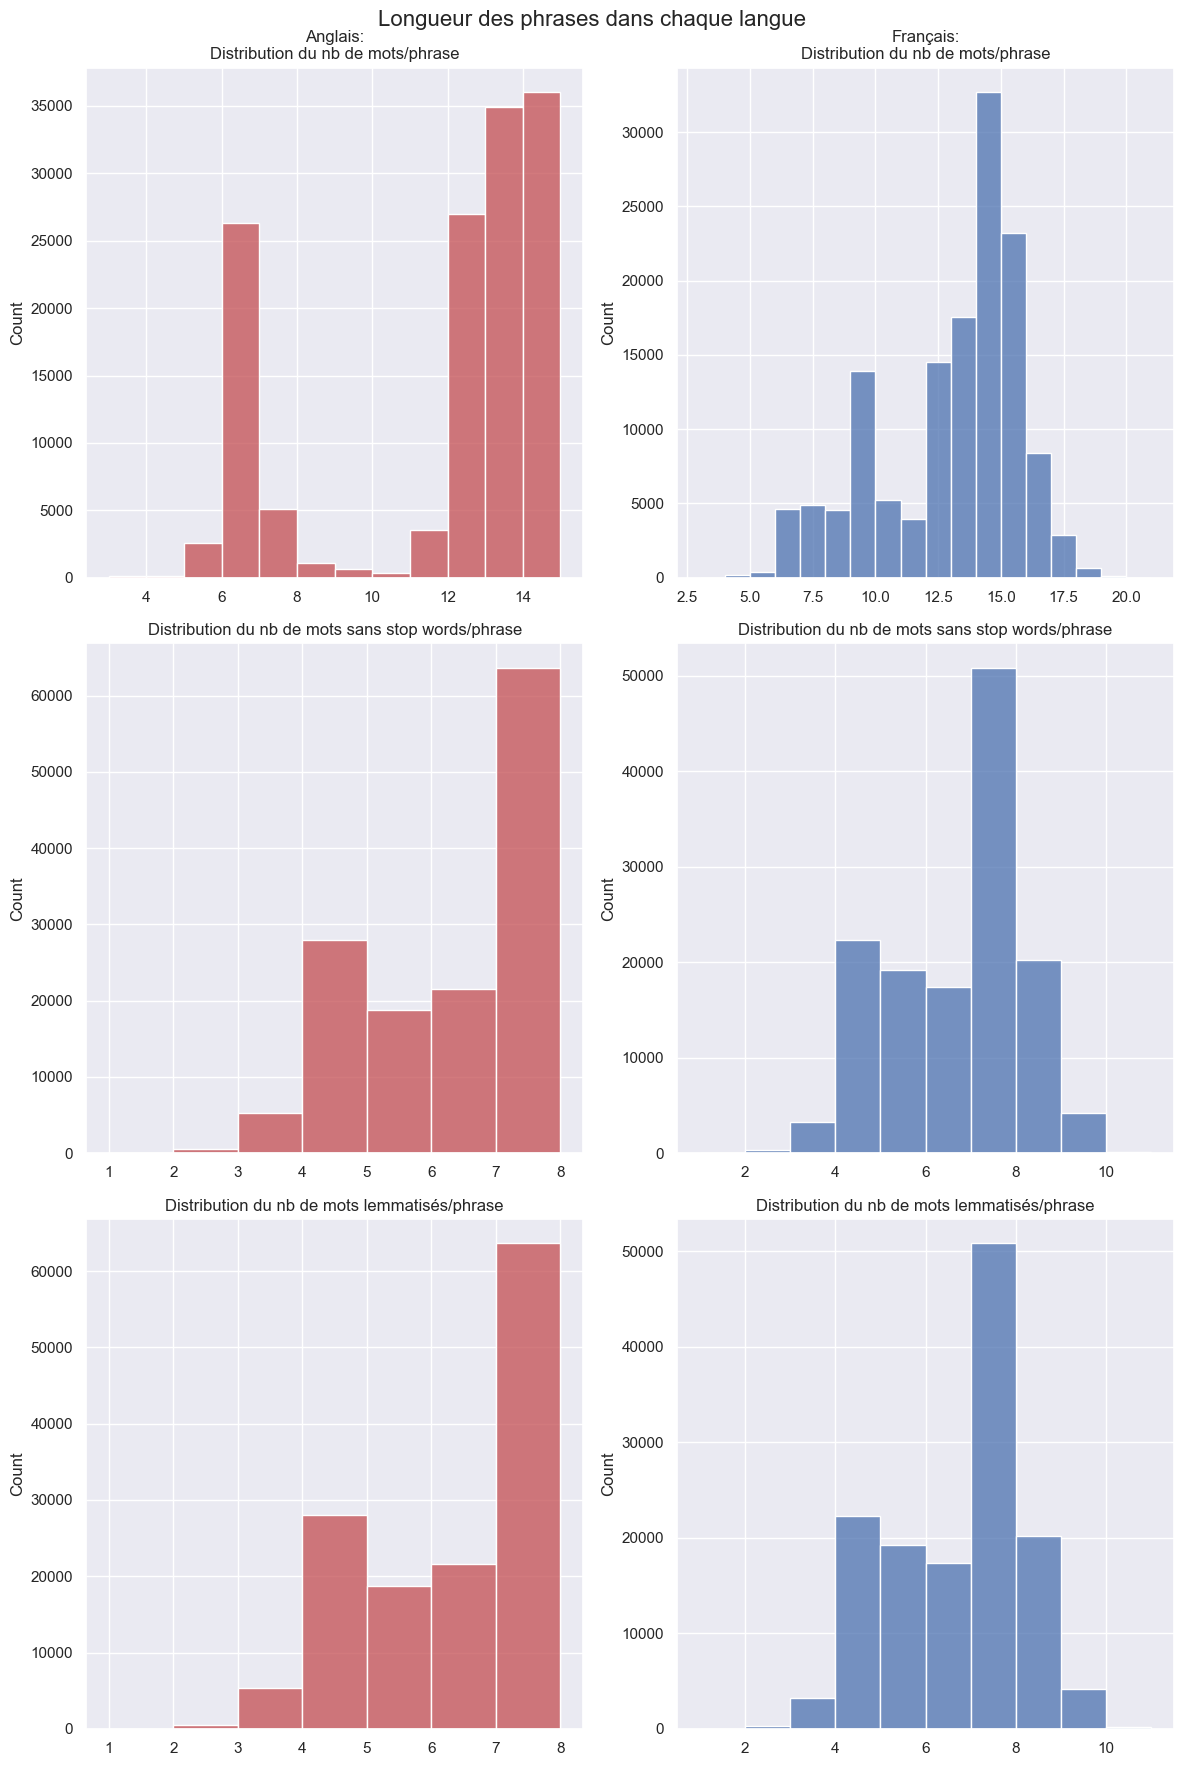

In [14]:
sns.set()
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

fig.suptitle("Longueur des phrases dans chaque langue", fontsize=16)
fig.tight_layout()
axes = axes.ravel()

sns.histplot(data=sent_len_en, binwidth=1, color='r', ax=axes[0]).set(title='Anglais:\nDistribution du nb de mots/phrase');
sns.histplot(data=sent_len_fr, binwidth=1, color='b', ax=axes[1]).set(title='Français:\nDistribution du nb de mots/phrase');
sns.histplot(data=sent_wo_sw_len_en, binwidth=1, color='r', ax=axes[2]).set(title='Distribution du nb de mots sans stop words/phrase');
sns.histplot(data=sent_wo_sw_len_fr, binwidth=1, color='b', ax=axes[3]).set(title='Distribution du nb de mots sans stop words/phrase');
sns.histplot(data=sent_lem_len_en, binwidth=1, color='r', ax=axes[4]).set(title='Distribution du nb de mots lemmatisés/phrase');
sns.histplot(data=sent_lem_len_fr, binwidth=1, color='b', ax=axes[5]).set(title='Distribution du nb de mots lemmatisés/phrase');

fig.tight_layout()
plt.show()

> **Représentation des co-occurences en réseau**

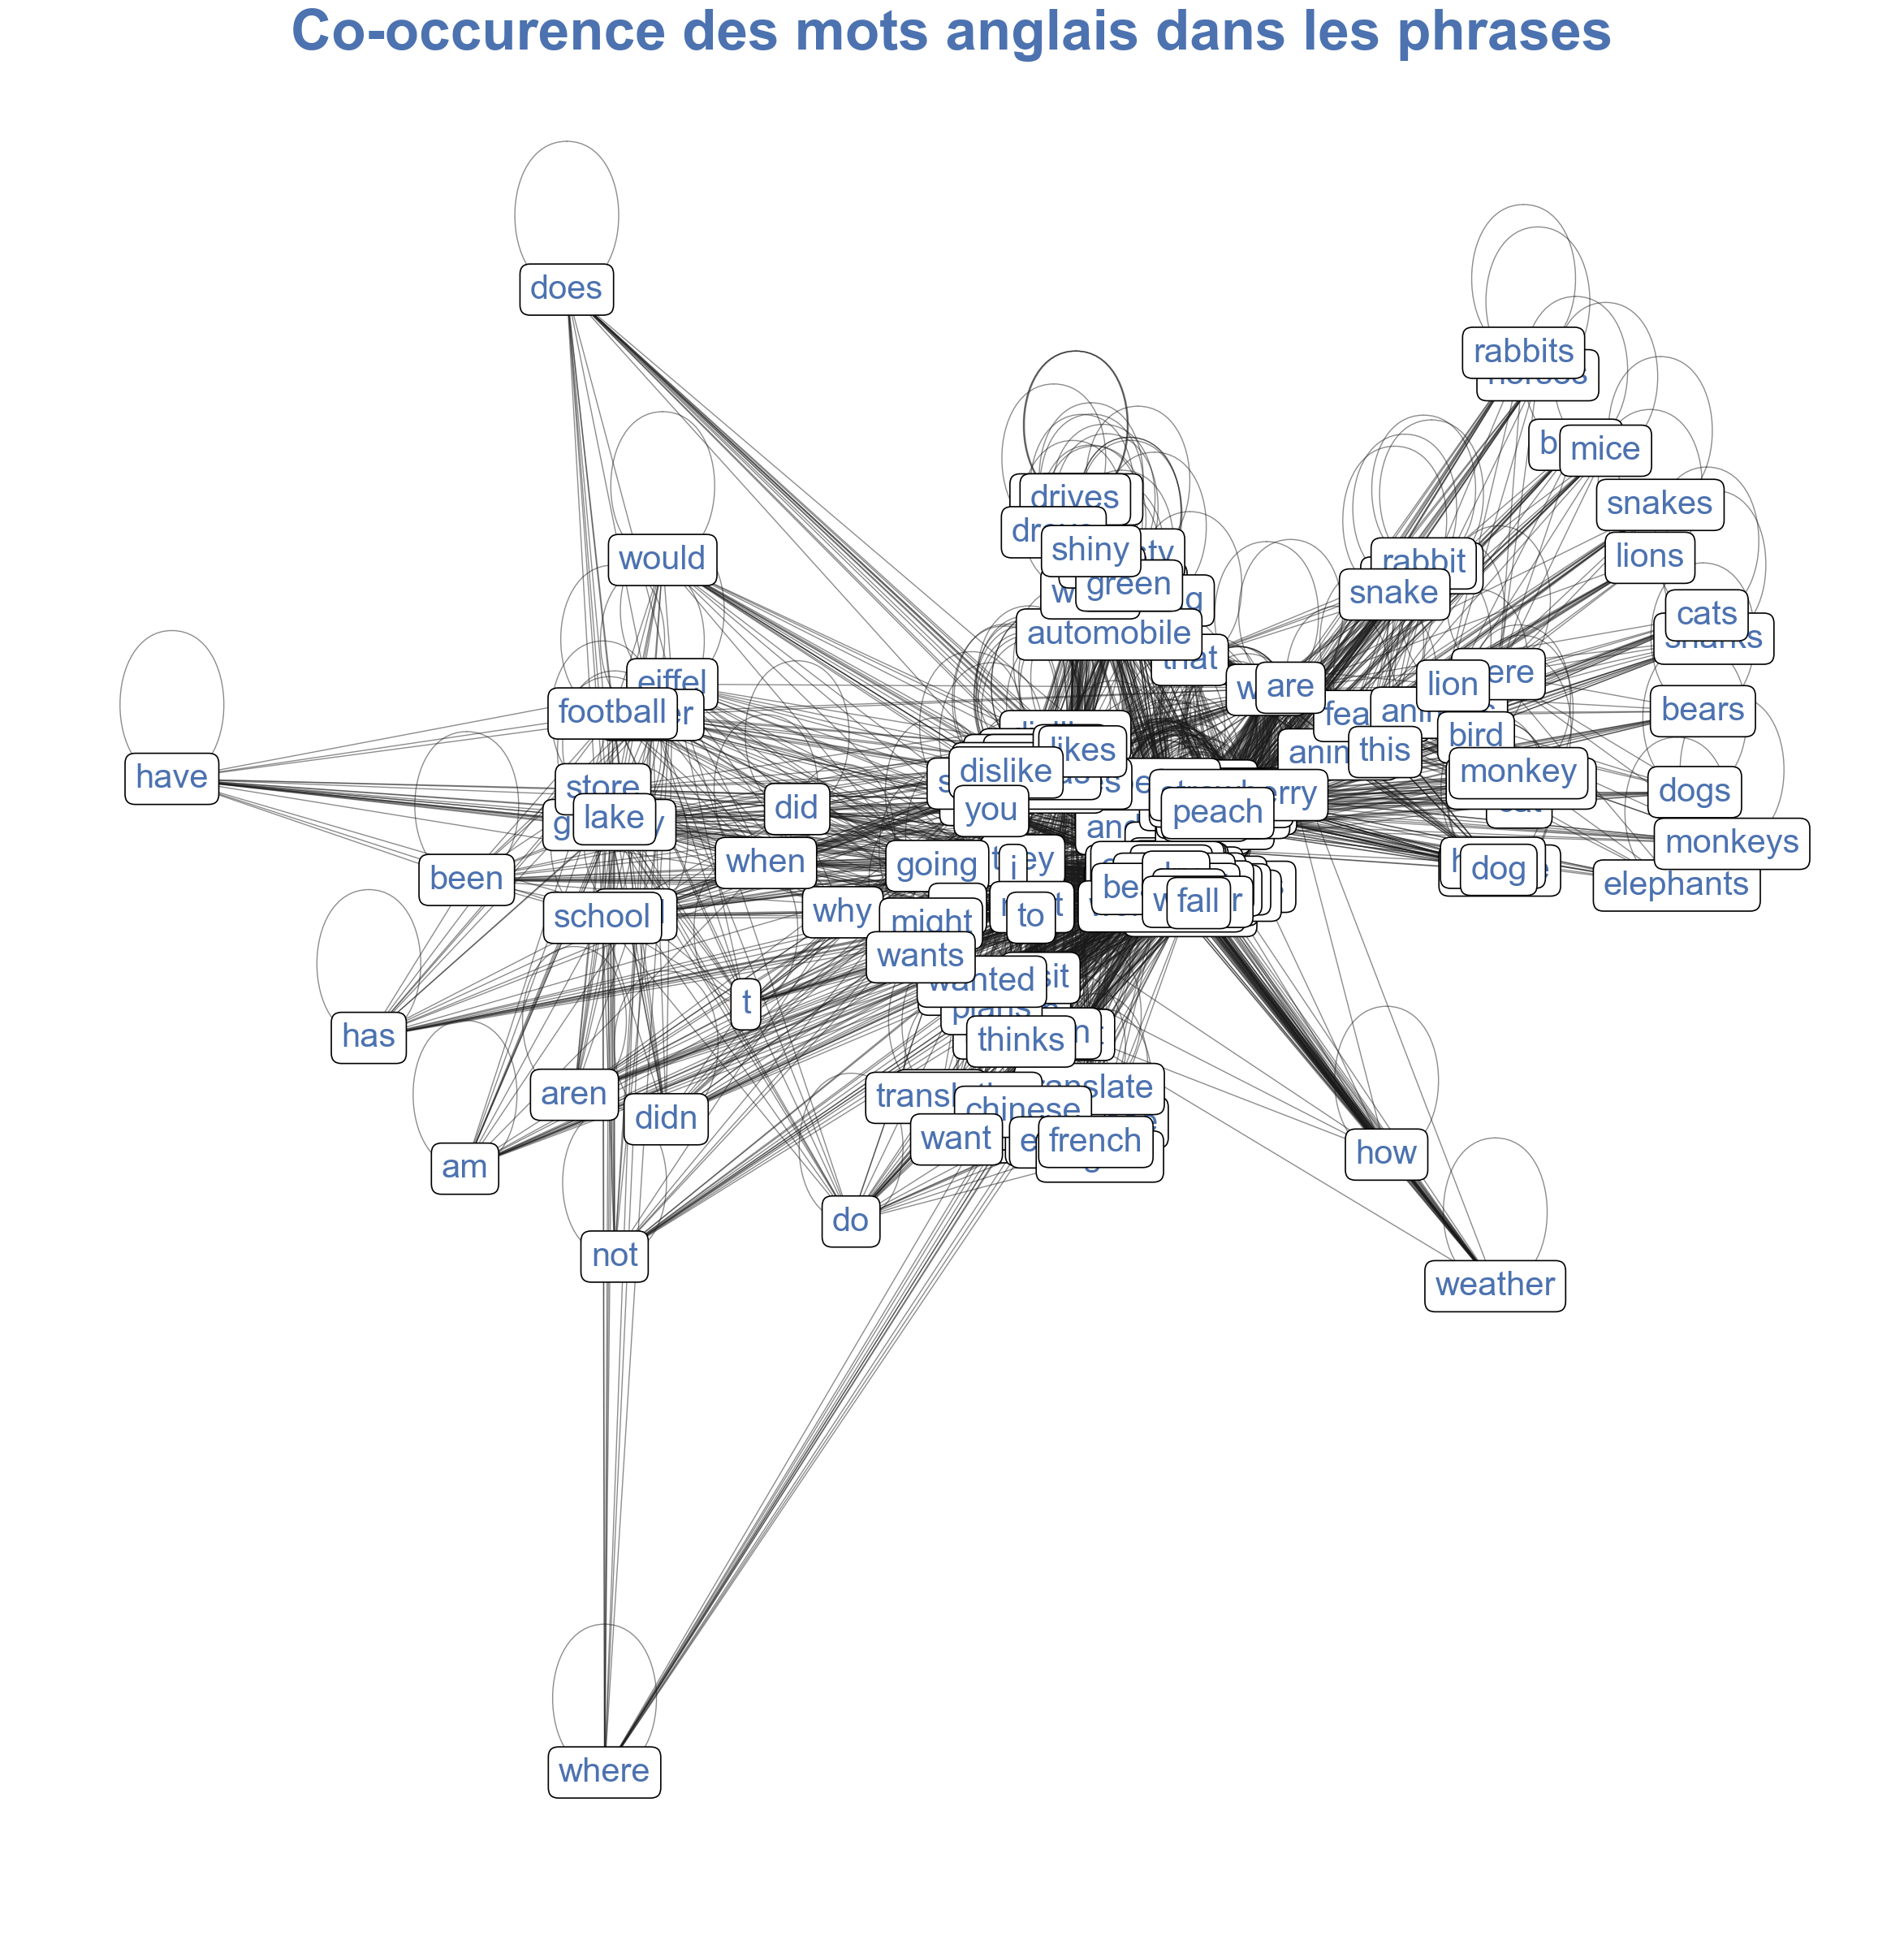

In [97]:
from gensim import corpora
dic = corpora.Dictionary(txt_split_en) # dictionnaire de tous les mots restant dans le token
# Equivalent (ou presque) de la DTM : DFM, Document Feature Matrix
dfm = [dic.doc2bow(tok) for tok in txt_split_en]

mes_labels = [k for k, v in dic.token2id.items()]

from gensim.matutils import corpus2csc
term_matrice = corpus2csc(dfm)

import numpy as np
term_matrice = np.dot(term_matrice, term_matrice.T)
import networkx as nx

G = nx.from_scipy_sparse_array(term_matrice)
G.add_nodes = dic
pos=nx.spring_layout(G)  # position des nodes


plt.figure(figsize=(30, 30));
plt.title("Co-occurence des mots anglais dans les phrases", fontsize=50, color='b',fontweight="bold")

nx.draw_networkx_nodes(G,pos, dic,
                       node_color=range(len(corpus_en)),
                       node_size=800,
                       cmap=plt.cm.Reds_r,
                       alpha=0.8);
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_labels(G,pos,dic,font_size=30, font_color='b',  bbox={"boxstyle": "round,pad=0.3", "fc":"white", "ec":"black", "lw":"1.2"} )

ax.margins(0.20)
plt.axis("off");

> **Distribution de certains mots dans une phrase**

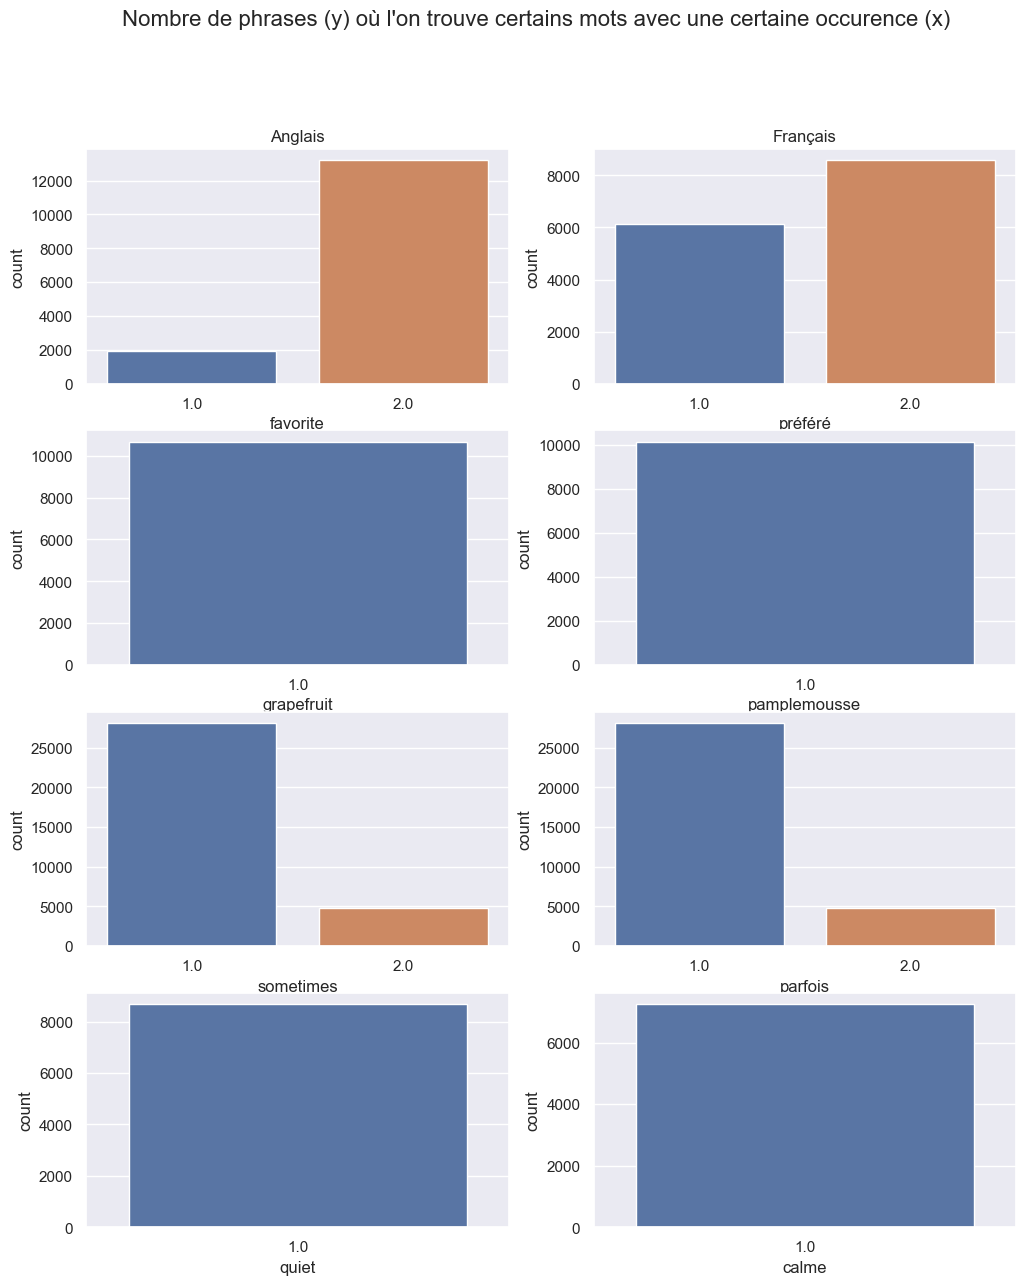

In [98]:
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
fig.suptitle("Nombre de phrases (y) où l'on trouve certains mots avec une certaine occurence (x)", fontsize=16)

axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')
sns.countplot(ax=axes[0,0],x=df_count_word_en['favorite'].loc[df_count_word_en['favorite']!=0.0]);
sns.countplot(ax=axes[1,0],x=df_count_word_en['grapefruit'].loc[df_count_word_en['grapefruit']!=0.0]);
sns.countplot(ax=axes[2,0],x=df_count_word_en['sometimes'].loc[df_count_word_en['sometimes']!=0.0]);
sns.countplot(ax=axes[3,0],x=df_count_word_en['quiet'].loc[df_count_word_en['quiet']!=0.0]);
sns.countplot(ax=axes[0,1],x=df_count_word_fr['préféré'].loc[df_count_word_fr['préféré']!=0.0]);
sns.countplot(ax=axes[1,1],x=df_count_word_fr['pamplemousse'].loc[df_count_word_fr['pamplemousse']!=0.0]);
sns.countplot(ax=axes[2,1],x=df_count_word_fr['parfois'].loc[df_count_word_fr['parfois']!=0.0]);
sns.countplot(ax=axes[3,1],x=df_count_word_fr['calme'].loc[df_count_word_fr['calme']!=0.0]);

=============================================

> **Création des dictionnaires de reference Anglais -> Français et Français -> Anglais**<br>

In [99]:
nb_mots_en = len(corpus_en)
nb_mots_fr = len(corpus_fr)

# On modifie df_count_word en indiquant la présence d'un mot par 1 (au lieu du nombre d'occurences)
df_count_word_en = df_count_word_en[df_count_word_en==0].fillna(1)
df_count_word_fr = df_count_word_fr[df_count_word_fr==0].fillna(1)

# On triche un peu parce que new et jersey sont toujours dans la même phrase et donc dans la même classe
df_count_word_en['new']=df_count_word_en['new']*2
df_count_word_fr['new']=df_count_word_fr['new']*2


> Pour evaluer l'efficacité, chargement des dictionnaires de reference (corrigés manuellement)

In [100]:
dict_FR_EN_ref = pd.read_csv('data/dict_fr_en2.csv',header=0,index_col=0, encoding ="utf-8", sep=';').T
dict_EN_FR_ref = pd.read_csv('data/dict_en_fr2.csv',header=0,index_col=0, encoding ="utf-8", sep=';').T
# display(dict_FR_EN_ref)
# display(dict_EN_FR_ref)

> Définition d'une fonction de **précision** du dictionnaire

In [101]:
def accuracy(dict_ref,dict):
    correct_words = 0
    
    for t in dict.columns:
        if t in dict_ref.columns:
            if str(dict[t]) == str(dict_ref[t]): 
                correct_words +=1
    print(correct_words," mots corrects / ",min(dict.shape[1],dict_ref.shape[1]))
    return correct_words/min(dict.shape[1],dict_ref.shape[1])

>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode non supervisée **KMeans**

In [102]:
# Création des dictionnaire Anglais -> Français

# Algorithme de K-means
init_centroids = df_count_word_fr.T
kmeans = KMeans(n_clusters = nb_mots_fr, n_init=1, max_iter=1, init=init_centroids, verbose=0)
# kmeans = KMedoids(n_clusters = nb_mots_fr, max_iter=10)

kmeans.fit(df_count_word_fr.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[kmeans.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
dict_EN_FR.index.name='Anglais'
dict_EN_FR = dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,dict_EN_FR)*100, 2)}%")
display(dict_EN_FR)


Dictionnaire Anglais -> Français:
169  mots corrects /  198
Précision du dictionnaire = 85.35%


Anglais,a,am,and,animal,animals,apple,apples,april,are,aren,...,when,where,white,why,winter,wonderful,would,yellow,you,your
Francais,une,vais,et,animal,animaux,pomme,pommes,avril,sont,allions,...,quand,où,blanche,pourquoi,hiver,merveilleux,voudrait,jaune,vous,votre


In [103]:
# Création des dictionnaire Français -> Anglais

# Algorithme de K-means
init_centroids = df_count_word_en.T
kmeans = KMeans(n_clusters = nb_mots_en, n_init=1, max_iter=1, init=init_centroids, verbose=0)
#kmeans = KMedoids(n_clusters = nb_mots_en, max_iter=10)

kmeans.fit(df_count_word_en.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[kmeans.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
dict_FR_EN.index.name='Francais'
dict_FR_EN = dict_FR_EN.T

print("Dictionnaire Français -> Anglais:")
print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,dict_FR_EN)*100, 2)}%")
display(dict_FR_EN)

Dictionnaire Français -> Anglais:
152  mots corrects /  330
Précision du dictionnaire = 46.06%


Francais,a,agréable,aimait,aime,aiment,aimeraient,aimez,aimons,aimé,aimée,...,à,école,éléphant,éléphants,épicerie,étaient,était,états,été,êtes
Anglais,drove,pleasant,disliked,likes,they,have,you,have,loved,have,...,fall,school,elephant,elephants,grocery,were,was,states,summer,have


>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode supervisée **KNN**

In [104]:
# Création des dictionnaire Anglais -> Français

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'minkowski'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[knn.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
knn_dict_EN_FR.index.name='Anglais'
knn_dict_EN_FR = knn_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,knn_dict_EN_FR)*100, 2)}%")
display(knn_dict_EN_FR)

Dictionnaire Anglais -> Français:
171  mots corrects /  198
Précision du dictionnaire = 86.36%


Anglais,a,am,and,animal,animals,apple,apples,april,are,aren,...,when,where,white,why,winter,wonderful,would,yellow,you,your
Francais,une,vais,et,animal,animaux,pomme,pommes,avril,sont,allions,...,quand,où,blanche,pourquoi,hiver,merveilleux,voudrait,jaune,vous,votre


In [105]:
# Création des dictionnaire Français -> Anglais

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'cosine'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[knn.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
knn_dict_FR_EN.index.name='Francais'
knn_dict_FR_EN = knn_dict_FR_EN.T

print("Dictionnaire Français -> Anglais:")
print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,knn_dict_FR_EN)*100, 2)}%")
display(knn_dict_FR_EN)

Dictionnaire Français -> Anglais:
240  mots corrects /  330
Précision du dictionnaire = 72.73%


Francais,a,agréable,aimait,aime,aiment,aimeraient,aimez,aimons,aimé,aimée,...,à,école,éléphant,éléphants,épicerie,étaient,était,états,été,êtes
Anglais,drove,pleasant,disliked,likes,they,would,you,we,loved,loved,...,fall,school,elephant,elephants,grocery,were,was,states,summer,did


>> **CountVectorization** (Bag of words) : Création des dictionnaires à l'aide de la méthode supervisée **Random Forest**

In [106]:
# Création des dictionnaire Anglais -> Français

# Algorithme de Random Forest
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[rf.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
rf_dict_EN_FR.index.name='Anglais'
rf_dict_EN_FR = rf_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,rf_dict_EN_FR)*100, 2)}%")
display(rf_dict_EN_FR)

Dictionnaire Anglais -> Français:
163  mots corrects /  198
Précision du dictionnaire = 82.32%


Anglais,a,am,and,animal,animals,apple,apples,april,are,aren,...,when,where,white,why,winter,wonderful,would,yellow,you,your
Francais,une,vais,et,animal,animaux,pomme,pommes,avril,sont,allez,...,quand,où,blanc,pourquoi,hiver,merveilleux,voudrait,jaune,vous,votre


In [107]:
# Création des dictionnaire Français -> Anglais

# Algorithme de Random Forest
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[rf.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
rf_dict_FR_EN.index.name='Francais'
rf_dict_FR_EN = rf_dict_FR_EN.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,rf_dict_FR_EN)*100, 2)}%")
display(rf_dict_FR_EN)

Dictionnaire Anglais -> Français:
173  mots corrects /  330
Précision du dictionnaire = 52.42%


Francais,a,agréable,aimait,aime,aiment,aimeraient,aimez,aimons,aimé,aimée,...,à,école,éléphant,éléphants,épicerie,étaient,était,états,été,êtes
Anglais,saw,nice,disliked,likes,they,where,you,we,loved,where,...,fall,school,elephant,elephants,store,were,was,states,summer,where


>> **Création des dictionnaires à l'aide du Word Embedding**

>>>
>>> MUSE est une bibliothèque Python pour l'intégration de mots multilingues, dont l'objectif est de fournir à la communauté, notamment
>>> des "Word Embedding" multilingues (embeddings fastText alignés dans un espace commun)
>>>
>>> <img src="https://github.com/facebookresearch/MUSE/blob/main/outline_all.png?raw=true" style = "width:800px">
>>>
>>> Facebook fournit des dictionnaires de référence. Ces embeddings sont des embeddings fastText Wikipedia pour 30 langues qui ont été alignés dans un espace espace vectoriel unique.
>>>
>>> Dans notre cas, nous allons utiliser 2 mini-dictionnaires (Français et Anglais) alignés
>>>
>>> FastText est une bibliothèque pour l'apprentissage de word embeddings et la classification de textes. L'équipe de recherche de Facebook a créé fastText en novembre 2015. Fast-Text est une extension de la bibliothèque word2vec. Elle s'appuie sur Word2Vec en apprenant des représentations vectorielles pour chaque mot et les n-grammes trouvés dans chaque mot. FastText suppose qu'un mot est formé de n-grammes de caractères.


In [108]:
from gensim.models import FastText
from gensim.models import KeyedVectors

In [109]:
# lecture des dictionnaires complet (+ de 2 M de mots)
# en_model= KeyedVectors.load_word2vec_format('./data/wiki.en.align.vec')
# fr_model= KeyedVectors.load_word2vec_format('./data/wiki.fr.align.vec')

In [110]:
# identification des mots à conserver dans les dictionnaires allégés
# word_en_to_keep = [en_model.most_similar(positive=[fr_model.get_vector(t)], topn=10)[i][0] for t in corpus_fr for i in range(10)]
# word_en_to_keep = [y for x in [word_en_to_keep, corpus_en] for y in x]
# word_en_to_keep.append("king")
# word_en_to_keep.append("queen")
# word_en_to_keep.append("man")
# word_en_to_keep.append("woman")
# word_fr_to_keep = [fr_model.most_similar(positive=[en_model.get_vector(t)], topn=10)[i][0] for t in corpus_en for i in range(10)]
# word_fr_to_keep = [y for x in [word_fr_to_keep, corpus_fr] for y in x]
# word_fr_to_keep.append("roi")
# word_fr_to_keep.append("reine")
# word_fr_to_keep.append("homme")

# def del_non_latin_words(liste):
#     r = re.compile(r"[a-zA-Z0-9áàâäãåçéèêëíìîïñóòôöõúùûüýÿæœÁÀÂÄÃÅÇÉÈÊËÍÌÎÏÑÓÒÔÖÕÚÙÛÜÝŸÆŒ]")
#     for w in liste:
#         if not r.match(w):
#             liste.remove(w)
#     return liste

# word_en_to_keep2 = del_non_latin_words(word_en_to_keep)
# word_en_to_keep2= pd.DataFrame(word_en_to_keep)[0].unique().tolist()
# print("Nombre de mots anglais conservés dans le mini-dictionnaire anglais :",len(word_en_to_keep2))

# word_fr_to_keep2 = del_non_latin_words(word_fr_to_keep)
# word_fr_to_keep2= pd.DataFrame(word_fr_to_keep)[0].unique().tolist()
# print("Nombre de mots français conservés dans le mini-dictionnaire français :",len(word_fr_to_keep2))

In [111]:
# Sauvegarde de dictionnaires allégés...
# import csv
# v_size = len(en_model.get_vector("a"))
# Ecriture d'un dictionbaire anglais mini
# with open('./data/mini.wiki.en.align.vec', 'w', newline='\n', encoding='UTF8') as csvfile:
#     line = csv.writer(csvfile, delimiter=' ')
#     line.writerow([len(word_en_to_keep2),v_size] )
#     for word in word_en_to_keep2:
#         v= en_model.get_vector(word)
#         l = [y for x in [[word], v] for y in x]
#         line.writerow(l)

# Ecriture d'un dictionbaire anglais mini
# with open('./data/mini.wiki.fr.align.vec', 'w', newline='\n', encoding='UTF8') as csvfile:
#     line = csv.writer(csvfile, delimiter=' ')
#     line.writerow([len(word_fr_to_keep2),v_size] )
#     for word in word_fr_to_keep2:
#         v= fr_model.get_vector(word)
#         l = [y for x in [[word], v] for y in x]
#         line.writerow(l)

In [112]:
# lecture des dictionnaires allégés
# en_model2= KeyedVectors.load_word2vec_format('./data/mini.wiki.en.align.vec')
# fr_model2= KeyedVectors.load_word2vec_format('./data/mini.wiki.fr.align.vec')

# Pretrained Word2Vec
en_model2= KeyedVectors.load_word2vec_format('./data/mini.wiki.en.align.vec')
fr_model2= KeyedVectors.load_word2vec_format('./data/mini.wiki.fr.align.vec')

nb_word_wiki_en = len(en_model2)
nb_word_wiki_fr = len(fr_model2)
print("Nombre de mots du dictionnaire anglais  allegé:",nb_word_wiki_en)
print("Nombre de mots du dictionnaire français allegé:",nb_word_wiki_fr)

Nombre de mots du dictionnaire anglais  allegé: 1739
Nombre de mots du dictionnaire français allegé: 1505


>> **Exemple** de calcul sur les **vecteurs de Word Embedding**, contenant de la sémantique

In [113]:
# traduction de : 'king' + 'man' - 'woman' = 'reine' 
vect1 = en_model2.get_vector("king")
vect2 = en_model2.get_vector("man")
vect3 = en_model2.get_vector("woman")
print("Traduction en français de ('king' - 'man' + 'woman') = ",fr_model2.most_similar(vect1-vect2+vect3)[0][0])


Traduction en français de ('king' - 'man' + 'woman') =  reine


In [114]:
fr_model2.most_similar("hiver")

[('hiver»', 0.7538578510284424),
 ('hiver,', 0.7442445158958435),
 ('hiver\xa0', 0.7428079843521118),
 ('hivernales', 0.69443678855896),
 ('hiver/printemps', 0.6840499639511108),
 ('automne', 0.6660692095756531),
 ('hivers', 0.6439971327781677),
 ('hivernal', 0.6414421200752258),
 ('hivernale', 0.6276507377624512),
 ('printemps', 0.6183713674545288)]

In [115]:
# Génération des traductions de tous les mots du chaque corpus
trad_fr = [fr_model2.most_similar(en_model2.get_vector(t))[0][0] for t in corpus_en]
trad_en = [en_model2.most_similar(positive=[fr_model2.get_vector(t)])[0][0] for t in corpus_fr]


In [116]:
# Création des dictionnaire Anglais -> Français, et affichage
we_dict_EN_FR = pd.DataFrame(data=trad_fr,index=corpus_en,columns=['Francais'])
we_dict_EN_FR.index.name='Anglais'
we_dict_EN_FR = we_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
display(we_dict_EN_FR)

Dictionnaire Anglais -> Français:


Anglais,a,am,and,animal,animals,apple,apples,april,are,aren,...,when,where,white,why,winter,wonderful,would,yellow,you,your
Francais,une,suis,et,animaux,animaux,apple,pommes,février,sont,soient,...,lorsque,où,blanc,pourquoi,hiver,merveilleuse,devait,jaune,peux,votre


In [117]:
# Création des dictionnaire Français -> Anglais, et affichage
we_dict_FR_EN = pd.DataFrame(data=trad_en,index=corpus_fr,columns=['Anglais'])
we_dict_FR_EN.index.name='Francais'
we_dict_FR_EN = we_dict_FR_EN.T

print("Dictionnaire Français -> Anglais :")
display(we_dict_FR_EN)

Dictionnaire Français -> Anglais :


Francais,a,agréable,aimait,aime,aiment,aimeraient,aimez,aimons,aimé,aimée,...,à,école,éléphant,éléphants,épicerie,étaient,était,états,été,êtes
Anglais,has,pleasant,loved,loves,enjoy,want,dare,they…,ange,beloved,...,to,school,elephant,elephants,grocery,were,was,states,been,ⅶ


>> **Affichage de la proximité des mots et de leur traduction**

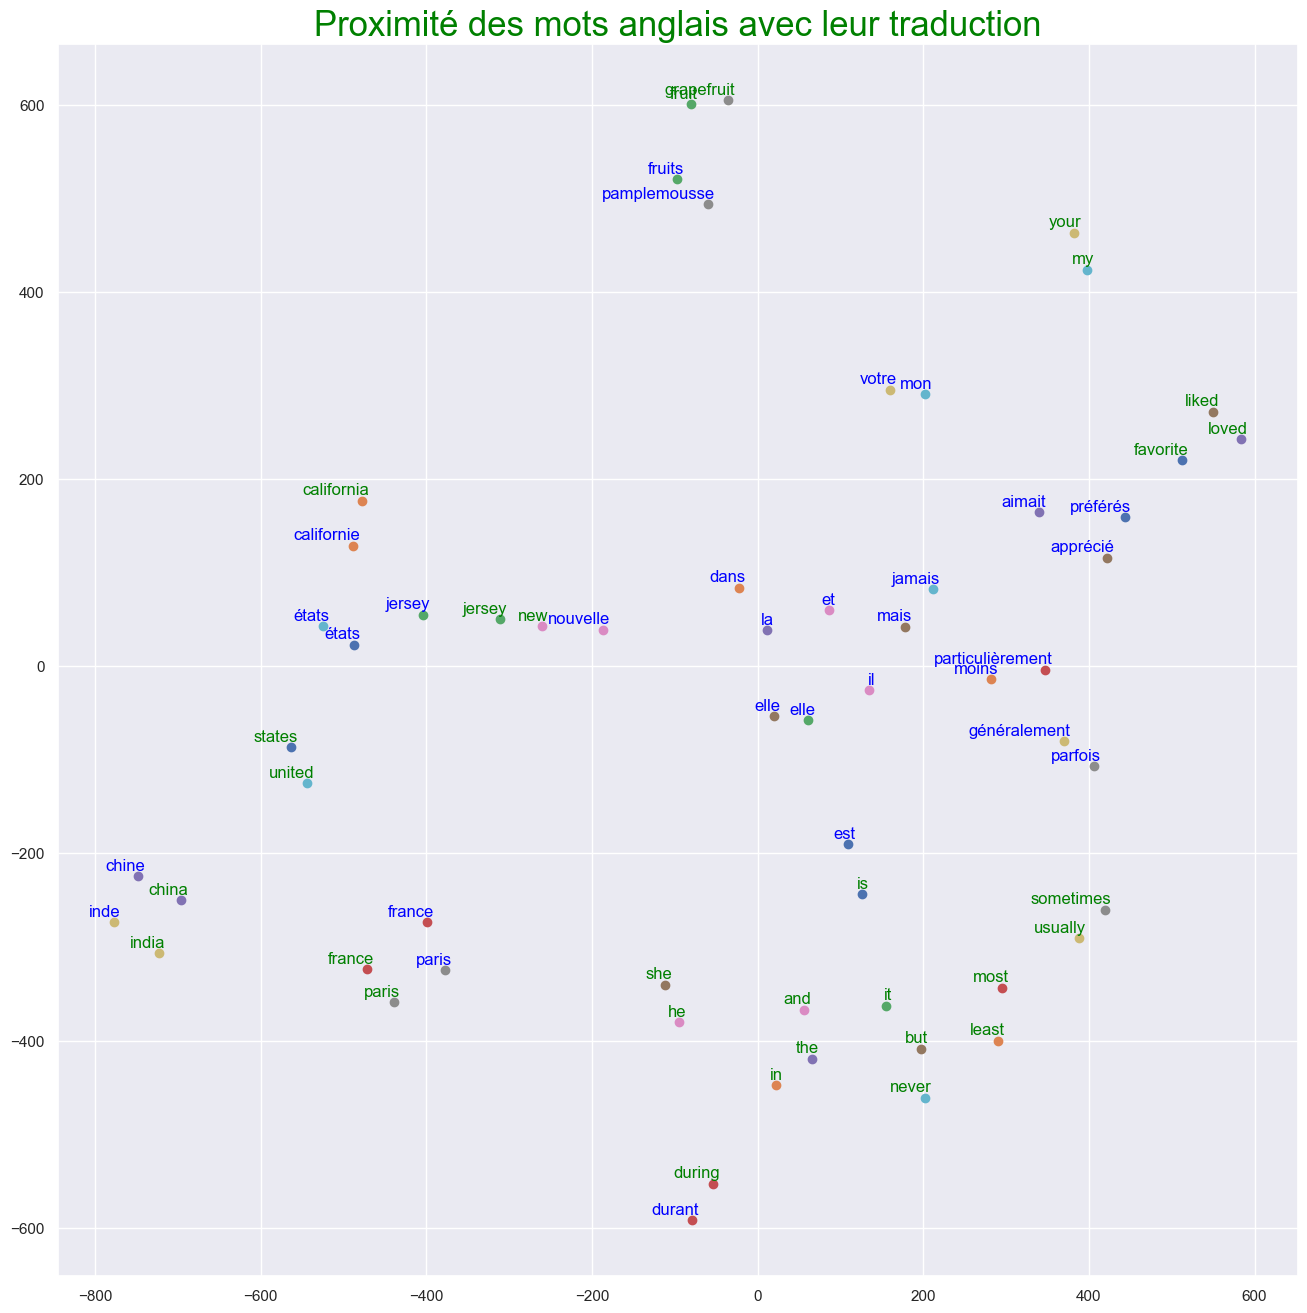

In [118]:
from sklearn.manifold import TSNE
global nb_occurences_en

"Creates and TSNE model and plots it"
labels = []
tokens = []

nb_words = 30
words_en = nb_occurences_en.iloc[:nb_words,0].index.tolist()
words_fr = (we_dict_EN_FR[words_en].T)['Francais'].tolist()

for word in words_en: #['is','sometimes','usually', 'favorite', 'loved', 'paris']: #corpus_en:
    tokens.append(en_model2[word])
    labels.append(word)
for word in words_fr: # ['est', 'parfois', 'généralement', 'préféré', 'aimé', 'paris']: # corpus_fr:
    tokens.append(fr_model2[word])
    labels.append(word)
tokens = pd.DataFrame(tokens)

tsne_model = TSNE(perplexity=6, n_components=2, init='pca', n_iter=5000, random_state=23)
new_values = tsne_model.fit_transform(tokens)

fig=plt.figure(figsize=(16, 16)) 
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
for i in range(len(x)):
    if i<nb_words  : color='green'
    else: color='blue'
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 color= color)
    plt.title("Proximité des mots anglais avec leur traduction", fontsize=25, color="green")
plt.show()

 



> **Illustration d'anomalies générées par les modèles CountVectorization:**<br>
> Exemple: "the" traduit par "fruit" au lieu de "le" ou "la"

In [119]:
word_en = 'the'
word_fr1 = 'le'
word_fr2 = 'la'
word_fr_pred = dict_EN_FR[word_en][0]
print("Nombre de fois que l'on trouve le mot '",word_en,"' dans le texte anglais :",df_count_word_en[word_en].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr_pred,"' dans le texte français :",df_count_word_fr[word_fr_pred].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr1,"' dans le texte français :",df_count_word_fr[word_fr1].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr2,"' dans le texte français :",df_count_word_fr[word_fr2].sum())

Nombre de fois que l'on trouve le mot ' the ' dans le texte anglais : 41221.0
Nombre de fois que l'on trouve le mot ' fruit ' dans le texte français : 23626.0
Nombre de fois que l'on trouve le mot ' le ' dans le texte français : 28877.0
Nombre de fois que l'on trouve le mot ' la ' dans le texte français : 39038.0


> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Anglais -> Français**

In [120]:
sentence1 = "paris is never freezing during november , but it is wonderful in october"
sentence2 = "the banana is their favorite fruit , but the grapefruit is your favorite" 
sentence3 = "that cat was my most loved animal"

print("\nTraduction à l'aide du dictionnaires de reference:")
display(dict_EN_FR_ref[split_sentence(sentence1,'en')[1]])
display(dict_EN_FR_ref[split_sentence(sentence2,'en')[1]])
display(dict_EN_FR_ref[split_sentence(sentence3,'en')[1]])
print("\n")

print("Traduction à l'aide du dictionnaires KMeans calculés:")
display(dict_EN_FR[split_sentence(sentence1,'en')[1]])
display(dict_EN_FR[split_sentence(sentence2,'en')[1]])
display(dict_EN_FR[split_sentence(sentence3,'en')[1]])
print("\n")

print("Traduction à l'aide du dictionnaires KNN calculés:")
display(knn_dict_EN_FR[split_sentence(sentence1,'en')[1]])
display(knn_dict_EN_FR[split_sentence(sentence2,'en')[1]])
display(knn_dict_EN_FR[split_sentence(sentence3,'en')[1]])
print("\n")

print("Traduction à l'aide du dictionnaires RF calculés:")
display(rf_dict_EN_FR[split_sentence(sentence1,'en')[1]])
display(rf_dict_EN_FR[split_sentence(sentence2,'en')[1]])
display(rf_dict_EN_FR[split_sentence(sentence3,'en')[1]])
print("\n")

print("Traduction à l'aide du dictionnaires Word Embedding FastText :")
display(we_dict_EN_FR[split_sentence(sentence1,'en')[1]])
display(we_dict_EN_FR[split_sentence(sentence2,'en')[1]])
display(we_dict_EN_FR[split_sentence(sentence3,'en')[1]])


Traduction à l'aide du dictionnaires de reference:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,il,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,le,banane,est,leur,préféré,fruit,mais,le,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,cher,animal




Traduction à l'aide du dictionnaires KMeans calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,fruit,banane,est,leur,préféré,fruit,mais,fruit,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal




Traduction à l'aide du dictionnaires KNN calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,fruit,banane,est,leur,préféré,fruit,mais,fruit,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal




Traduction à l'aide du dictionnaires RF calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,fruit,banane,est,leur,préféré,fruit,mais,fruit,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal




Traduction à l'aide du dictionnaires Word Embedding FastText :


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,froid,durant,février,mais,elle,est,merveilleuse,dans,février


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,la,bananes,est,leurs,préférés,fruits,mais,la,pamplemousse,est,votre,préférés


Anglais,that,cat,was,my,most,loved,animal
Francais,que,cat,fut,mon,particulièrement,aimait,animaux


> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Français -> Anglais**

In [121]:
sentence1 = "paris est jamais le gel en novembre , mais il est merveilleux en octobre ."
sentence2 = "la banane est leur fruit préféré , mais le pamplemousse est votre favori ." 
sentence3 = "ce chat était mon animal le plus aimé"

print("\nTraduction à l'aide du dictionnaire de reference:")
display(dict_FR_EN_ref[split_sentence(sentence1,'fr')[1]])
display(dict_FR_EN_ref[split_sentence(sentence2,'fr')[1]])
display(dict_FR_EN_ref[split_sentence(sentence3,'fr')[1]])
print("\n")

print("Traduction à l'aide du dictionnaire Kmeans calculés:")
display(dict_FR_EN[split_sentence(sentence1,'fr')[1]])
display(dict_FR_EN[split_sentence(sentence2,'fr')[1]])
display(dict_FR_EN[split_sentence(sentence3,'fr')[1]])
print("\n")

print("Traduction à l'aide du dictionnaire KNN calculés:")
display(knn_dict_FR_EN[split_sentence(sentence1,'fr')[1]])
display(knn_dict_FR_EN[split_sentence(sentence2,'fr')[1]])
display(knn_dict_FR_EN[split_sentence(sentence3,'fr')[1]])
print("\n")

print("Traduction à l'aide du dictionnaire RF calculés:")
display(rf_dict_FR_EN[split_sentence(sentence1,'fr')[1]])
display(rf_dict_FR_EN[split_sentence(sentence2,'fr')[1]])
display(rf_dict_FR_EN[split_sentence(sentence3,'fr')[1]])
print("\n")

print("Traduction à l'aide du dictionnaires Word Embedding FastText :")
display(we_dict_FR_EN[split_sentence(sentence1,'fr')[1]])
display(we_dict_FR_EN[split_sentence(sentence2,'fr')[1]])
display(we_dict_FR_EN[split_sentence(sentence3,'fr')[1]])


Traduction à l'aide du dictionnaire de reference:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,the,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,the,banana,is,their,fruit,favorite,but,the,grapefruit,is,your,favorite


Francais,ce,chat,était,mon,animal,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,animal,the,most,loved




Traduction à l'aide du dictionnaire Kmeans calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,grapefruit,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,grapefruit,grapefruit,is,football,have


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,grapefruit,most,loved




Traduction à l'aide du dictionnaire KNN calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,fruit,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,fruit,grapefruit,is,your,favorite


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,fruit,most,loved




Traduction à l'aide du dictionnaire RF calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,most,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,most,grapefruit,is,your,where


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,most,most,loved




Traduction à l'aide du dictionnaires Word Embedding FastText :


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,the,freeze,in,june,but,he,is,wonderful,in,june


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,the,banana,is,their,fruit,favorite,but,the,grapefruit,is,your,favourite


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,that,cat,was,my,animal,the,less,ange
